In [1]:
import pandas as pd
import numpy as np
from math import *
from sklearn.model_selection import train_test_split
from math import sqrt
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import itertools
from itertools import chain
from typing import Iterable, Sequence, Tuple
import time
pd.__version__

'0.18.1'

In [2]:
## Read dataset

path = "D:\\Affine_Projects\\WB_Warner_Bros\\MMM\\AD_Creation\\Lego_AD\\19072019"
raw_ad = pd.read_excel(path+"\\MMM_Lego_AD3.xlsx")
ad = raw_ad.sort_values(by=['Title','Week Number'])
print(ad.shape)
ad.head()

(605, 71)


Total Units  Total Spend  ASP Week Ending                 Title  \
0            0          0.0  0.0  2016-09-10  Cars-3-Driven-to-Win   
1            0          0.0  0.0  2016-09-17  Cars-3-Driven-to-Win   
2            0          0.0  0.0  2016-09-24  Cars-3-Driven-to-Win   
3            0          0.0  0.0  2016-10-01  Cars-3-Driven-to-Win   
4            0          0.0  0.0  2016-10-08  Cars-3-Driven-to-Win   

   Total Revenue  Sales Trend-Not Flatten  Sales Trend  Meta Critic Score  \
0            0.0                 0.000256     0.000256                 72   
1            0.0                 0.000311     0.000311                 72   
2            0.0                 0.002146     0.002146                 72   
3            0.0                 0.001160     0.001160                 72   
4            0.0                 0.000969     0.000969                 72   

   Metacritic number of user ratings        ...         pos_thanksgiving  \
0                                 25        ...                      0.0   
1                                 25        ...                      0.0   
2                                 25        ...                      0.0   
3                                 25        ...                      0.0   
4                                 25        ...                      0.0   

   pos_christmas  Facebook_1st week  Video_1st week  Search_1st week  \
0            0.0                0.0             0.0              0.0   
1            0.0                0.0             0.0              0.0   
2            0.0                0.0             0.0              0.0   
3            0.0                0.0             0.0              0.0   
4            0.0                0.0             0.0              0.0   

   Display_1st week  Facebook_2nd week  Video_2nd week  Search_2nd week  \
0               0.0                0.0             0.0              0.0   
1               0.0                0.0             0.0              0.0   
2               0.0                0.0             0.0              0.0   
3               0.0                0.0             0.0              0.0   
4               0.0                0.0             0.0              0.0   

   Display_2nd week  
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0  

[5 rows x 71 columns]

### For Adstock Calculation

In [3]:
def roundoff_adstock(x):
    if(x==0):
        return 100
    else:
        log_10 = log10(x)
        floor_log10 = floor(log_10)
        lower_power10 = pow(10,floor_log10)
        first_digit = floor(x/lower_power10)
        final = first_digit * lower_power10
        return final


def add_single_adstock_col(df,col,decay_sat_par_val_dict,decay_param,saturation_param):
    df = df[[col]]
    decay = decay_sat_par_val_dict[decay_param]
    saturation = decay_sat_par_val_dict[saturation_param]
    df["pvals_"+col]=0
    df["adstock_"+col]=0
    for index in df.index:
        curr_val = df.loc[index,col]
        if(index==0):
            df.loc[index,"pvals_"+col] = 1- (1/exp((curr_val*saturation)/roundoff_adstock(curr_val)))
            df.loc[index,"adstock_"+col] = curr_val
        else:
            prev_pvals = df.loc[index-1,"pvals_"+col]
            df.loc[index,"pvals_"+col] = 1 - ((1-prev_pvals*exp(-1*decay))/exp((curr_val*saturation)/roundoff_adstock(curr_val)))
            df.loc[index,"adstock_"+col] = curr_val+(df.loc[index-1,"adstock_"+col]*df.loc[index,"pvals_"+col])
    df["ads_"+col+"_D"+str(decay_param)+"_S"+str(saturation_param)] = df["adstock_"+col]
    df = df.drop([col,"pvals_"+col,"adstock_"+col],axis=1)
    return df  

def get_adstock(df,adstock_cols,decay_min,decay_max,saturation_min,saturation_max):
    df2 = df.copy()
    for col in adstock_cols:
        decay_param = decay_min
        while(decay_param<=decay_max):
            saturation_param = saturation_min
            while(saturation_param<=saturation_max):
                s_time = time.time()
                df1 = add_single_adstock_col(df[[col]],col,decay_sat_par_val_dict,decay_param,saturation_param)
                e_time = time.time()
                colName = df1.columns[0]
                df2[colName] = df1[colName]
                saturation_param = saturation_param +1
            decay_param = decay_param+1
    return df2


In [4]:
## For Different adstock combination
traditional_cols = ['TVSpend','TradeDisplayPlacement','TradeDisplayPlacement_Combined']
digital_cols = ['Video','Search','POSRebate','POSRebate_Combined','TubularViews']
other_cols = ['Display','Facebook']
decay_sat_par_val_dict = {
    1:0.0625,
    2:0.125,
    3:0.25,
    4:0.5,
    5:1,
    6:1.5,
    7:2,
    8:2.5,
    9:0.3,
    10:0.4,
    11:0.6,
    12:0.7,
    13:0.8,
    14:1.2,
    15:1.4
}
traditional_saturation_min = 5
traditional_saturation_max = 8
traditional_decay_min = 1
traditional_decay_max = 3
digital_saturation_min = 1
digital_saturation_max = 5
digital_decay_min = 3
digital_decay_max = 5
other_saturation_min = 1 
other_saturation_max = 15
other_decay_min = 9
other_decay_max = 15

In [5]:
title_list = ad['Title'].unique()
df_traditional = pd.DataFrame()
df_digital = pd.DataFrame()
df_other = pd.DataFrame()
for title in title_list:
    ad_title = ad[ad['Title']==title]
    ad_title = ad_title.reset_index()
    df_traditional_title = get_adstock(ad_title,traditional_cols,traditional_decay_min,traditional_decay_max,traditional_saturation_min,traditional_saturation_max)
    df_traditional = df_traditional.append(df_traditional_title,ignore_index=True)
    df_digital_title = get_adstock(ad_title,digital_cols,digital_decay_min,digital_decay_max,digital_saturation_min,digital_saturation_max)
    df_digital = df_digital.append(df_digital_title,ignore_index=True)
    df_other_title = get_adstock(ad_title,other_cols,other_decay_min,other_decay_max,other_saturation_min,other_saturation_max)
    df_other = df_other.append(df_other_title,ignore_index=True)


In [6]:
df_traditional = df_traditional.drop(['index'],axis=1)
df_digital = df_digital.drop(['index'],axis=1)
df_other = df_other.drop(['index'],axis=1)

In [7]:
## Combining Traditional and Digital to get a single AD. Dropping some cols from digital 
## which are already present in traditional so as to merge properly

digital_cols_drop = ['Total Units','ASP','Total Spend','Week Ending','Total Revenue','Sales Trend-Not Flatten','Sales Trend','Meta Critic Score','Metacritic number of user ratings','Is Action',
                    'Is Adventure', 'Is Open World', 'Is Fighting', 'Is Other','Physical ASP', 'Digital ASP','Thanksgiving Flag','Christmas Flag', 
                     '1st week', '2nd week', 'black Friday week number','Install base', 'same genre', 'different genre', 'TVSpend', 'Facebook',
                     'Video','Search', 'Display','POSRebate','TradeDisplayPlacement','POSRebate_Combined','TradeDisplayPlacement_Combined','TubularViews','Calender Week','Month','Games Developed Before this game',
                    'Total Games','Games with WB as Publisher','First Game of Studio(Years Ago)','Average Metacritic Score','Average Revenue',
                    'No of prequels from franchise','Last Game of Franchise','Average Gap in Game Release(Years)','Jan','Feb','Mar','Apr','May','Jun','Jul',
                     'Aug','Sep','Oct','Nov','Dec','pos_thanksgiving','pos_christmas','Facebook_1st week','Video_1st week','Search_1st week',
                    'Display_1st week','Facebook_2nd week','Video_2nd week','Search_2nd week','Display_2nd week']
other_cols_drop = digital_cols_drop
df_ads_merge = pd.merge(df_traditional,df_digital.drop(digital_cols_drop,axis=1),how='inner',on=['Title','Week Number','Week Number New'])
df_ads_merge = pd.merge(df_ads_merge,df_other.drop(other_cols_drop,axis=1),how='inner',on=['Title','Week Number','Week Number New'])
print(df_ads_merge.columns)
df_ads_merge.to_excel(path+"\\adstock_file.xlsx")
df_ads_merge.head()

Index(['Total Units', 'Total Spend', 'ASP', 'Week Ending', 'Title',
       'Total Revenue', 'Sales Trend-Not Flatten', 'Sales Trend',
       'Meta Critic Score', 'Metacritic number of user ratings',
       ...
       'ads_Facebook_D15_S6', 'ads_Facebook_D15_S7', 'ads_Facebook_D15_S8',
       'ads_Facebook_D15_S9', 'ads_Facebook_D15_S10', 'ads_Facebook_D15_S11',
       'ads_Facebook_D15_S12', 'ads_Facebook_D15_S13', 'ads_Facebook_D15_S14',
       'ads_Facebook_D15_S15'],
      dtype='object', length=394)


Total Units  Total Spend  ASP Week Ending                 Title  \
0            0          0.0  0.0  2016-09-10  Cars-3-Driven-to-Win   
1            0          0.0  0.0  2016-09-17  Cars-3-Driven-to-Win   
2            0          0.0  0.0  2016-09-24  Cars-3-Driven-to-Win   
3            0          0.0  0.0  2016-10-01  Cars-3-Driven-to-Win   
4            0          0.0  0.0  2016-10-08  Cars-3-Driven-to-Win   

   Total Revenue  Sales Trend-Not Flatten  Sales Trend  Meta Critic Score  \
0            0.0                 0.000256     0.000256                 72   
1            0.0                 0.000311     0.000311                 72   
2            0.0                 0.002146     0.002146                 72   
3            0.0                 0.001160     0.001160                 72   
4            0.0                 0.000969     0.000969                 72   

   Metacritic number of user ratings          ...           \
0                                 25          ...            
1                                 25          ...            
2                                 25          ...            
3                                 25          ...            
4                                 25          ...            

   ads_Facebook_D15_S6  ads_Facebook_D15_S7  ads_Facebook_D15_S8  \
0                  0.0                  0.0                  0.0   
1                  0.0                  0.0                  0.0   
2                  0.0                  0.0                  0.0   
3                  0.0                  0.0                  0.0   
4                  0.0                  0.0                  0.0   

   ads_Facebook_D15_S9  ads_Facebook_D15_S10  ads_Facebook_D15_S11  \
0                  0.0                   0.0                   0.0   
1                  0.0                   0.0                   0.0   
2                  0.0                   0.0                   0.0   
3                  0.0                   0.0                   0.0   
4                  0.0                   0.0                   0.0   

   ads_Facebook_D15_S12  ads_Facebook_D15_S13  ads_Facebook_D15_S14  \
0                   0.0                   0.0                   0.0   
1                   0.0                   0.0                   0.0   
2                   0.0                   0.0                   0.0   
3                   0.0                   0.0                   0.0   
4                   0.0                   0.0                   0.0   

   ads_Facebook_D15_S15  
0                   0.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0  

[5 rows x 394 columns]

## For Capping

In [8]:
### For Capping the very low values. Uncomment df_ads_merge only if capping is required

def capped(row,col,lower):
    if(row[col]<lower):
        return lower
#     elif(row[col]>upper):
#         return upper
    else:
        return row[col]
def get_capped_df(df,col,lower):
    df[col] = df.apply(lambda row:capped(row,col,lower),axis=1)
    return df

df_ads_capped = get_capped_df(df_ads_merge.copy(),'Total Units',1000)
#df_ads_capped = get_capped_df(df_ads_capped.copy(),'TubularViews',123559,6855385) 
df_ads_merge = df_ads_capped

df_ads_merge 

Total Units   Total Spend        ASP Week Ending  \
0           1000      0.000000   0.000000  2016-09-10   
1           1000      0.000000   0.000000  2016-09-17   
2           1000      0.000000   0.000000  2016-09-24   
3           1000      0.000000   0.000000  2016-10-01   
4           1000      0.000000   0.000000  2016-10-08   
5           1000      0.000000   0.000000  2016-10-15   
6           1000      0.000000   0.000000  2016-10-22   
7           1000      0.000000   0.000000  2016-10-29   
8           1000      0.000000   0.000000  2016-11-05   
9           1000      0.000000   0.000000  2016-11-12   
10          1000      0.000000   0.000000  2016-11-19   
11          1000      0.000000   0.000000  2016-11-26   
12          1000      0.000000   0.000000  2016-12-03   
13          1000      0.000000   0.000000  2016-12-10   
14          1000      0.000000   0.000000  2016-12-17   
15          1000      0.000000   0.000000  2016-12-24   
16          1000      0.000000   0.000000  2016-12-31   
17          1000      0.000000   0.000000  2017-01-07   
18          1000      0.000000   0.000000  2017-01-14   
19          1000      0.000000   0.000000  2017-01-21   
20          1000      0.000000   0.000000  2017-01-28   
21          1000      0.000000   0.000000  2017-02-04   
22          1000      0.000000   0.000000  2017-02-11   
23          1000      0.000000   0.000000  2017-02-18   
24          1000      0.000000   0.000000  2017-02-25   
25          1000      0.000000   0.000000  2017-03-04   
26          1000      0.000000   0.000000  2017-03-11   
27          1000      0.000000   0.000000  2017-03-18   
28          1000      0.000000   0.000000  2017-03-25   
29          1000    168.659341   0.000000  2017-04-01   
..           ...           ...        ...         ...   
575         1121    835.739130  30.671512  2018-08-18   
576         1000    835.739130  30.535732  2018-08-25   
577         1000    835.739130  25.673462  2018-09-01   
578         1011    835.739130  25.619814  2018-09-08   
579         1000    835.739130  25.482957  2018-09-15   
580         1000    835.739130  23.578490  2018-09-22   
581         1189    835.739130  22.513835  2018-09-29   
582         1000    835.739130  22.717625  2018-10-06   
583         1000    835.739130  23.008238  2018-10-13   
584         1000    835.739130  23.555934  2018-10-20   
585         1000    835.739130  23.227433  2018-10-27   
586         1128    835.739130  21.790425  2018-11-03   
587         1000    358.173913  21.685475  2018-11-10   
588         1036      0.000000  18.526182  2018-11-17   
589         4380  16184.800000  20.264036  2018-11-24   
590         2484   1371.200000  20.164783  2018-12-01   
591         1543      0.000000  21.687082  2018-12-08   
592         2463   7626.285714  21.109935  2018-12-15   
593         5116  13346.000000  20.724122  2018-12-22   
594         4765   7776.857143  21.242871  2018-12-29   
595         2215   1542.857143  23.056933  2019-01-05   
596         1057      0.000000  22.971233  2019-01-12   
597         1000      0.000000  23.154531  2019-01-19   
598         1000      0.000000  23.850252  2019-01-26   
599         1000      0.000000  21.754943  2019-02-02   
600         1000      0.000000  21.927333  2019-02-09   
601         1000      0.000000  21.971815  2019-02-16   
602         1000    106.909091  22.331680  2019-02-23   
603         1089   3663.163636  21.795770  2019-03-02   
604         1000   1569.927273  21.972032  2019-03-09   

                                           Title  Total Revenue  \
0                           Cars-3-Driven-to-Win       0.000000   
1                           Cars-3-Driven-to-Win       0.000000   
2                           Cars-3-Driven-to-Win       0.000000   
3                           Cars-3-Driven-to-Win       0.000000   
4                           Cars-3-Driven-to-Win       0.000000   
5                           Cars-3-Driven-to-Win       0.000000   
6

In [9]:
## Function to calculate natural log of the columns.
def get_ln_values(df,col):
    df1 = df.copy()
    df1["ln_"+col] = 0
    for index in df.index:
        value = df.loc[index,col]
        if(value>0):
            cal = log(value)
            if(cal>0):
                df1.loc[index,"ln_"+col] = cal
    return df1

all_columns = df_ads_merge.columns
not_ln_columns = ['Week Ending','Title','Total Revenue','Total Spend','Sales Trend','Meta Critic Score','Metacritic number of user ratings',
                 'Is Action','Is Adventure','Is Open World','Is Fighting','Is Other','Thanksgiving Flag','Christmas Flag','1st week','2nd week','black Friday week number','Install base','same genre',
                 'different genre','Calender Week','Month','Games Developed Before this game','Total Games',
                'Games with WB as Publisher','First Game of Studio(Years Ago)','Average Metacritic Score','Average Revenue',
                'No of prequels from franchise','Last Game of Franchise','Average Gap in Game Release(Years)','Jan','Feb','Mar','Apr','May','Jun','Jul',
                  'Aug','Sep','Oct','Nov','Dec','pos_thanksgiving','pos_christmas','Facebook_1st week','Video_1st week','Search_1st week',
                    'Display_1st week','Facebook_2nd week','Video_2nd week','Search_2nd week','Display_2nd week']

ln_columns = np.setdiff1d(all_columns,not_ln_columns,assume_unique=True)
df_ads = df_ads_merge.copy()
for col in ln_columns:
    df1 = get_ln_values(df_ads_merge.copy()[[col]],col)
    ln_column_name = df1.columns[1]
    df_ads[ln_column_name] = df1[ln_column_name]

#df_ads.to_excel(path+"\\ln_adstock_file.xlsx")    
df_ads.head()


Total Units  Total Spend  ASP Week Ending                 Title  \
0         1000          0.0  0.0  2016-09-10  Cars-3-Driven-to-Win   
1         1000          0.0  0.0  2016-09-17  Cars-3-Driven-to-Win   
2         1000          0.0  0.0  2016-09-24  Cars-3-Driven-to-Win   
3         1000          0.0  0.0  2016-10-01  Cars-3-Driven-to-Win   
4         1000          0.0  0.0  2016-10-08  Cars-3-Driven-to-Win   

   Total Revenue  Sales Trend-Not Flatten  Sales Trend  Meta Critic Score  \
0            0.0                 0.000256     0.000256                 72   
1            0.0                 0.000311     0.000311                 72   
2            0.0                 0.002146     0.002146                 72   
3            0.0                 0.001160     0.001160                 72   
4            0.0                 0.000969     0.000969                 72   

   Metacritic number of user ratings           ...             \
0                                 25           ...              
1                                 25           ...              
2                                 25           ...              
3                                 25           ...              
4                                 25           ...              

   ln_ads_Facebook_D15_S6  ln_ads_Facebook_D15_S7  ln_ads_Facebook_D15_S8  \
0                     0.0                     0.0                     0.0   
1                     0.0                     0.0                     0.0   
2                     0.0                     0.0                     0.0   
3                     0.0                     0.0                     0.0   
4                     0.0                     0.0                     0.0   

   ln_ads_Facebook_D15_S9  ln_ads_Facebook_D15_S10  ln_ads_Facebook_D15_S11  \
0                     0.0                      0.0                      0.0   
1                     0.0                      0.0                      0.0   
2                     0.0                      0.0                      0.0   
3                     0.0                      0.0                      0.0   
4                     0.0                      0.0                      0.0   

   ln_ads_Facebook_D15_S12  ln_ads_Facebook_D15_S13  ln_ads_Facebook_D15_S14  \
0                      0.0                      0.0                      0.0   
1                      0.0                      0.0                      0.0   
2                      0.0                      0.0                      0.0   
3                      0.0                      0.0                      0.0   
4                      0.0                      0.0                      0.0   

   ln_ads_Facebook_D15_S15  
0                      0.0  
1                      0.0  
2                      0.0  
3                      0.0  
4                      0.0  

[5 rows x 735 columns]

In [10]:
# function for splitting train test dataset based on games or randomly
from sklearn.utils import shuffle

def getTrainTestGames(df_X,df_Y,testGames):
    X_test = df_X[df_X['Title'].isin(testGames)]
    X_train = df_X[~df_X['Title'].isin(testGames)]
    Y_test = df_Y[df_Y.index.isin(X_test.index)]
    Y_train = df_Y[df_Y.index.isin(X_train.index)]
    return X_train,X_test,Y_train,Y_test

def getSplitTrainTest(df_X,df_Y,testSize):
    X_train,X_test,Y_train,Y_test = train_test_split(df_X,df_Y,test_size=testSize,random_state=7)
    return (X_train,X_test,Y_train,Y_test)

### Function for scaling the data
from sklearn import preprocessing
def getScaledData(X):
    #scaler = preprocessing.StandardScaler().fit(X)
    X1 = X.copy().drop(['Week Ending','Title'],axis=1)
    scaler = preprocessing.MinMaxScaler().fit(X1)
    scaled_arr = scaler.transform(X1) 
    df_AD_X1_scaled=  pd.DataFrame(scaled_arr,columns =X1.columns)
    df = pd.concat([X[['Week Ending','Title']],df_AD_X1_scaled],axis=1)
    # (X,Y,scaler)
    # (df,scaler)
    return (X,scaler)

### Function to create LR model
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
def getLinearModel(X_train,Y_train):
    lr_model_ols = sm.OLS(Y_train.values,X_train.values).fit()
    return (lr_model_ols,X_train.columns)  

### Calculate Various Metrics
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def Rsquare(yoriginal,ypred):
    SS_Residual = sum((yoriginal-ypred)**2)
    SS_Total = sum((yoriginal-np.mean(yoriginal))**2)
    r_squared = 1 - (float(SS_Residual))/SS_Total
    return r_squared
def adjRsquare(yoriginal,ypred,numIndVar):
    SS_Residual = sum((yoriginal-ypred)**2)
    SS_Total = sum((yoriginal-np.mean(yoriginal))**2)
    r_squared = 1 - (float(SS_Residual))/SS_Total
    adjusted_r_squared = 1 - (1-r_squared)*(len(yoriginal)-1)/(len(yoriginal)-numIndVar-1)
    return adjusted_r_squared
def replace_to_percent(df_add,cols):
    df_add['Total Spend'] = df_add[list(cols)].sum(axis=1)   
    for col in cols:
        df_add[col] = (df_add[col] /  df_add['Total Spend'])*100
    return df_add
def w_mape(y_true,y_pred):
    abs_error_percent = np.abs((y_true- y_pred)/y_true)*100
    return (sum(y_true*abs_error_percent)/sum(y_true))
    

In [11]:
def getPreProcessData(df,colsForModel,nonMarketingCols,marketingLnCols,testGames):
    dict_preprocess_data = {}
    dfAds = df
    dfAds = dfAds[dfAds['ln_Total Units']!=0]
    dfAdsPruned = dfAds.dropna()
    
    dfAdsPruned = shuffle(dfAdsPruned,random_state=7)
    df_Y = dfAdsPruned['ln_Total Units']
    df_X = dfAdsPruned.drop(['ln_Total Units'],axis=1)
    
    X_scaled,scaler = getScaledData(df_X)
    X_train,X_test,Y_train,Y_test = getTrainTestGames(X_scaled,df_Y,testGames)
    #X_train,X_test,Y_train,Y_test = getSplitTrainTest(X_scaled,df_Y,.2)
    dict_preprocess_data['X_train_all']= X_train
    dict_preprocess_data['X_test_all'] = X_test
    X_train = X_train.drop(['Week Ending','Title'],axis=1)
    X_test = X_test.drop(['Week Ending','Title'],axis=1)
    XTrainScaledConst = X_train[colsForModel]
    XTestScaledConst = X_test[colsForModel]
    XTrainScaledConst = sm.add_constant(XTrainScaledConst)
    XTestScaledConst = sm.add_constant(XTestScaledConst,has_constant='add')
    dict_preprocess_data['Y_train'] = Y_train
    dict_preprocess_data['Y_test']= Y_test
    dict_preprocess_data['XTrainScaledConst']= XTrainScaledConst
    dict_preprocess_data['XTestScaledConst']= XTestScaledConst
    dict_preprocess_data['scaler'] = scaler
    return dict_preprocess_data    

In [12]:
def calculateLinearRegression(df_overall,colsForModel,nonMarketingCols,marketingLnCols,testGames):
    dict_preprocess_data = getPreProcessData(df_overall,colsForModel,nonMarketingCols,marketingLnCols,testGames)
    XTrainScaledConst = dict_preprocess_data['XTrainScaledConst']
    XTrainScaledConst = XTrainScaledConst
    XTestScaledConst = dict_preprocess_data['XTestScaledConst']
    XTestScaledConst = XTestScaledConst
    X_train_all = dict_preprocess_data['X_train_all']
    X_test_all = dict_preprocess_data['X_test_all']
    Y_train = dict_preprocess_data['Y_train']
    Y_test = dict_preprocess_data['Y_test']
    scaler = dict_preprocess_data['scaler']
    lr_model_ols,column_names = getLinearModel(XTrainScaledConst,Y_train)
    model_param_dict = getModelParamDict(lr_model_ols,column_names,XTrainScaledConst,XTestScaledConst,X_train_all,X_test_all,Y_train,Y_test,scaler)
    return model_param_dict

In [13]:
def getModelParamDict(lr_model_ols,column_names,XTrainScaledConst,XTestScaledConst,X_train_all,X_test_all,Y_train,Y_test,scaler):
    model_dict = {}
    model_dict["lr_model_ols"] = lr_model_ols
    model_dict["column_names"] = column_names
    model_dict["XTrainScaledConst"] = XTrainScaledConst
    model_dict["XTestScaledConst"] = XTestScaledConst
    model_dict["X_train_all"] = X_train_all
    model_dict["X_test_all"] = X_test_all
    model_dict["Y_train"] = Y_train
    model_dict["Y_test"] = Y_test
    model_dict["scaler"] = scaler
    #print(model_dict["column_names"])
    return model_dict

# Contribution Calculation

In [14]:
### For Calculating Contributions
def getRawContributions(XTrainScaledConst,ypred_exp,betaCoef,column_names):
    raw_contibutions = np.zeros(XTrainScaledConst.shape)
    for i in range(0,len(ypred_exp)):
        for j in range(0,len(column_names)):
            if(j!=0):
                contribution = ypred_exp[i]-(ypred_exp[i]/exp(betaCoef[j]*XTrainScaledConst.values[i][j]))
            else:
                contribution = ypred_exp[i]-(ypred_exp[i]/exp(betaCoef[j]))
            raw_contibutions[i][j] = contribution
    return raw_contibutions

def getScaledContributions(XTrainScaledConst,ypred_exp,raw_contibutions,column_names):
    scaled_contribution = np.zeros(XTrainScaledConst.shape)
    for i in range(0,len(ypred_exp)):
        cont_factor = np.sum(np.absolute(raw_contibutions[i]))
        y_sum_cont = np.sum(raw_contibutions[i])
        y_actual = ypred_exp[i]
        for j in range(0,len(column_names)):
            scaled_contribution[i][j] = raw_contibutions[i][j] + ((abs(raw_contibutions[i][j])*(y_actual-y_sum_cont))/cont_factor)
    return scaled_contribution

def getPercentMarketingContribution(scaled_contribution_df,marketing_cols):
    total = scaled_contribution_df.sum()
    total = total.reset_index()
    total.columns= ['variables','value']
    #     'ln_ads_POSRebate_D1_S5'
    #marketing_cols= ['ln_ads_TVSpend_D1_S8','ln_ads_Facebook_D3_S5','ln_ads_Video_D3_S4','ln_ads_Display_D3_S5','ln_ads_Search_D3_S4','ln_POSRebate','ln_TradeDisplayPlacement']
    def add_marketing_variable(row):
        if(row['variables'] in marketing_cols):
            return "marketing"
        else:
            return "others"

    total["Marketing_Variables"] = total.apply(lambda row:add_marketing_variable(row),axis=1)
    total = total[total["variables"]!="Title"]
    grouped = total.groupby('Marketing_Variables')['value'].sum().reset_index()
    sum_value = grouped['value'].sum()
    grouped['percent'] = (grouped['value']/sum_value)*100
    total["Percent Marketing Contribution"] = (total["value"] / total["value"].sum())*100
    return (grouped,total)

### For VIF Analysis
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
def variance_inflation_factors(exog_df):
    '''
    Parameters
    ----------
    exog_df : dataframe, (nobs, k_vars)
        design matrix with all explanatory variables, as for example used in
        regression.

    Returns
    -------
    vif : Series
        variance inflation factors
    '''
    exog_df = add_constant(exog_df)
    vifs = pd.Series(
        [1 / (1. - OLS(exog_df[col].values, 
                       exog_df.loc[:, exog_df.columns != col].values).fit().rsquared) 
         for col in exog_df],
        index=exog_df.columns,
        name='VIF'
    )
    return vifs



### Model by removing Pre Order from AD

In [15]:
## Model params of presentation 


nonMarketingCols = ['Calender Week', 'Dec', 'Mar', 'Jul', '1st week', '2nd week', 'Is Action', 'Is Open World',\
                    'same genre', 'different genre', 'Week Number', 'TubularViews']

marketingLnCols = ['ln_ads_TVSpend_D1_S8','ln_ads_Facebook_D13_S7','ln_ads_Video_D3_S4','ln_ads_Display_D13_S15',\
                   'ln_ads_Search_D3_S4','ln_POSRebate','ln_TradeDisplayPlacement']


marketing_non_ads_cols = ['TVSpend','Facebook','Video','Display','Search','POSRebate','TradeDisplayPlacement']
colsForModel = nonMarketingCols
colsForModel.extend(marketingLnCols)
df_overall = df_ads.copy()
df_overall = df_overall[(df_overall['Week Number']>=0)]
df_overall = df_overall.drop(['Install base'],axis=1)
print(colsForModel)
#---------------------------#
testGames= ['Lego Ninjago Movie Videogame']
model_dict = calculateLinearRegression(df_overall,colsForModel,nonMarketingCols,marketingLnCols,testGames)
lr_model_ols = model_dict["lr_model_ols"]
XTrainScaledConst = model_dict["XTrainScaledConst"]
XTestScaledConst = model_dict["XTestScaledConst"]
Y_train = model_dict["Y_train"]
Y_test = model_dict["Y_test"]
X_train_all = model_dict["X_train_all"]
X_test_all = model_dict["X_test_all"]
column_names = model_dict["column_names"]
ypredict_train = lr_model_ols.predict(XTrainScaledConst)
ypredict_test = lr_model_ols.predict(XTestScaledConst)
train_mape_ln = mean_absolute_percentage_error(Y_train,ypredict_train.values)
test_mape_ln = mean_absolute_percentage_error(Y_test,ypredict_test.values)
train_mape = mean_absolute_percentage_error(np.exp(Y_train.values),np.exp(ypredict_train.values))
test_mape = mean_absolute_percentage_error(np.exp(Y_test.values),np.exp(ypredict_test.values))
train_rsquare =  Rsquare(Y_train,ypredict_train.values)
train_adjrsquare = adjRsquare(Y_train,ypredict_train.values,XTrainScaledConst.shape[1]-1)
betaCoef = lr_model_ols.params
ypred = lr_model_ols.predict(XTrainScaledConst)
ypred_exp = np.exp(ypred.values)
y_pred_exp_test = np.exp(ypredict_test.values)

['Calender Week', 'Dec', 'Mar', 'Jul', '1st week', '2nd week', 'Is Action', 'Is Open World', 'same genre', 'different genre', 'Week Number', 'TubularViews', 'ln_ads_TVSpend_D1_S8', 'ln_ads_Facebook_D13_S7', 'ln_ads_Video_D3_S4', 'ln_ads_Display_D13_S15', 'ln_ads_Search_D3_S4', 'ln_POSRebate', 'ln_TradeDisplayPlacement']


C:\Users\Sarthak\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [16]:
y_pred_exp_test

array([ 2791.65047835, 13970.79333232,  2902.60118531,  2964.69971596,
        7372.64364529,  2938.28451257, 22387.39378808, 29967.56068808,
        3441.91176989,  3120.89205254,  3087.97188502,  2953.69540301,
       29131.32047523,  3040.41482846,  8645.77718192, 13723.23375396,
        2851.93527596,  8446.81303519,  4110.74016554, 13886.09680359,
        3073.55233345,  4319.51721499,  3491.81450848, 21985.48477582,
        4278.19321123,  4187.43088383,  3269.82703763, 13890.95684376,
        3223.85749649, 13344.49737511,  3202.80348286,  3050.53226907,
        3485.06825057,  3255.01883821,  2803.5633585 ,  4195.45570151,
        2895.98113529,  2757.51192409,  3296.04093665, 13902.65339235,
        2907.45925768, 17951.80792883, 12323.72050205,  2794.08779456,
        2544.50586986,  3394.80956182,  2993.58486724, 10158.88125464,
        2675.27189384,  3207.44838844,  2833.83027851,  2770.99108767,
        2087.13970802])

In [17]:
#X_train_all.to_excel(path+"\\X_train_all.xlsx")

In [18]:
lr_model_ols.summary(xname=list(column_names))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     23.33
Date:                Fri, 27 Sep 2019   Prob (F-statistic):           5.39e-45
Time:                        17:38:40   Log-Likelihood:                -268.05
No. Observations:                 272   AIC:                             576.1
Df Residuals:                     252   BIC:                             648.2
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        7.8133      0.259     30.219      0.000       7.304       8.323
Calender Week               -0.0025      0.004     -0.694      0.488      -0.010       0.005
Dec                          0.5859      0.179      3.270      0.001       0.233       0.939
Mar                          0.3004      0.157      1.919      0.056      -0.008       0.609
Jul                          0.1518      0.157      0.964      0.336      -0.158       0.462
1st week                     0.2279      0.422      0.540      0.589      -0.603       1.059
2nd week                    -0.4554      0.440     -1.034      0.302      -1.323       0.412
Is Action                    0.1677      0.113      1.482      0.140      -0.055       0.391
Is Open World                0.4571      0.135      3.375      0.001       0.190       0.724
same genre                  -0.3496      0.423     -0.826      0.410      -1.183       0.484
different genre             -0.0443      0.109     -0.409      0.683      -0.258       0.169
Week Number                  0.0004      0.006      0.075      0.940      -0.011       0.012
TubularViews              1.288e-07   3.41e-08      3.777      0.000    6.16e-08    1.96e-07
ln_ads_TVSpend_D1_S8         0.0034      0.015      0.223      0.824      -0.027       0.034
ln_ads_Facebook_D13_S7       0.0251      0.019      1.321      0.188      -0.012       0.063
ln_ads_Video_D3_S4           0.0301      0.021      1.407      0.161      -0.012       0.072
ln_ads_Display_D13_S15       0.0381      0.016      2.344      0.020       0.006       0.070
ln_ads_Search_D3_S4          0.0049      0.022      0.220      0.826      -0.039       0.048
ln_POSRebate                 0.0062      0.012      0.530      0.597      -0.017       0.029
ln_TradeDisplayPlacement     0.0875      0.014      6.045      0.000       0.059       0.116
==============================================================================
Omnibus:                        5.636   Durbin-Watson:                   1.861
Prob(Omnibus):                  0.060   Jarque-Bera (JB):                5.330
Skew:                           0.317   Prob(JB):                       0.0696
Kurtosis:                       3.262   Cond. No.                     3.26e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.26e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [19]:
## Vif
df_vif = XTrainScaledConst
df_vif = df_vif.drop(['const'],axis=1)
vif = variance_inflation_factors(df_vif)
vif = vif.reset_index()
vif = vif.sort_values(by=['VIF'],ascending=0)
vif

index        VIF
0                      const  40.089987
15        ln_ads_Video_D3_S4   6.127836
13      ln_ads_TVSpend_D1_S8   4.989385
11               Week Number   4.595686
17       ln_ads_Search_D3_S4   4.037850
12              TubularViews   3.191721
14    ln_ads_Facebook_D13_S7   2.962945
19  ln_TradeDisplayPlacement   2.570432
16    ln_ads_Display_D13_S15   2.254891
1              Calender Week   1.974271
18              ln_POSRebate   1.959773
2                        Dec   1.888742
6                   2nd week   1.408766
8              Is Open World   1.350492
5                   1st week   1.293324
3                        Mar   1.226387
7                  Is Action   1.204849
9                 same genre   1.172043
10           different genre   1.130028
4                        Jul   1.105367

In [20]:
df_predicted_train_original = X_train_all.copy()
df_predicted_test_original = X_test_all.copy()

df_predicted_train_original['ln_Units'] = Y_train.values
df_predicted_train_original['ln_Units-Predicted'] = ypredict_train.values
df_predicted_train_original['Units'] = np.exp(Y_train.values)
df_predicted_train_original['Units-Predicted'] = np.exp(ypredict_train.values)

df_predicted_test_original['ln_Units'] = Y_test.values
df_predicted_test_original['ln_Units-Predicted'] = ypredict_test.values
df_predicted_test_original['Units'] = np.exp(Y_test.values)
df_predicted_test_original['Units-Predicted'] = np.exp(ypredict_test.values)

#df_predicted_train_original[['Total Units','Week Ending','Title','Week Number','Units','Units-Predicted']].to_excel(path+"\\prediction_train.xlsx")
#df_predicted_test_original[['Total Units','Week Ending','Title','Week Number','Units','Units-Predicted']].to_excel(path+"\\predicted_test.xlsx")

In [21]:
df_predicted_test_original["Residuals Percentage"] = (df_predicted_test_original['Units']-df_predicted_test_original['Units-Predicted'])/df_predicted_test_original['Units']
df_predicted_train_original["Residuals Percentage"] = (df_predicted_train_original['Units']-df_predicted_train_original['Units-Predicted'])/df_predicted_train_original['Units']
df_predicted_test_original

Total Units   Total Spend        ASP Week Ending  \
353         2032  8.062910e+02  32.355450  2018-08-25   
315        16444  3.427625e+05  38.627469  2017-12-02   
339         2323  8.062910e+02  36.719428  2018-05-19   
336         2262  3.148958e+03  43.780540  2018-04-28   
320         7896  7.376067e+04  40.788473  2018-01-06   
337         2305  1.475624e+03  38.301791  2018-05-05   
308        10106  8.451193e+04  54.218260  2017-10-14   
305        15560  3.844760e+05  57.579091  2017-09-23   
348         2848  3.160005e+03  33.107746  2018-07-21   
333         4263  2.417092e+04  41.357254  2018-04-07   
323         3321  2.753115e+03  49.623948  2018-01-27   
354         2827  1.511029e+04  34.355052  2018-09-01   
307        10889  4.769290e+05  57.326927  2017-10-07   
334         2857  3.608594e+03  43.785001  2018-04-14   
313         7103  9.204957e+04  34.236242  2017-11-18   
310         7783  3.249425e+04  55.251082  2017-10-28   
344         2190  8.062910e+02  34.856603  2018-06-23   
314        92421  2.539992e+06  33.895411  2017-11-25   
332        12267  4.208539e+05  28.682124  2018-03-31   
319        17168  3.326548e+05  35.966992  2017-12-30   
341         4121  2.530001e+04  35.198458  2018-06-02   
330        18456  3.652056e+05  29.065211  2018-03-17   
346         3584  1.492858e+04  33.591575  2018-07-07   
306        15679  5.564209e+05  56.867577  2017-09-30   
331         8701  1.524787e+05  30.016122  2018-03-24   
328         4288  6.710006e+03  31.350153  2018-03-03   
321         3492  2.753115e+03  46.084685  2018-01-13   
316        16245  1.530317e+05  39.387976  2017-12-09   
324         3127  2.753115e+03  45.416533  2018-02-03   
318        44485  5.332519e+05  38.670734  2017-12-23   
325         3278  2.753115e+03  45.098514  2018-02-10   
342         3384  1.701658e+04  36.095250  2018-06-09   
347         3909  1.728229e+04  33.871657  2018-07-14   
322         3656  2.753115e+03  50.074960  2018-01-20   
350         2088  8.062910e+02  34.026775  2018-08-04   
329         4077  1.495763e+04  31.256864  2018-03-10   
340         2948  8.062910e+02  37.546244  2018-05-26   
357         1867  8.062910e+02  32.976101  2018-09-22   
326         6817  1.498031e+05  44.030302  2018-02-17   
317        17839  1.907249e+05  39.138577  2017-12-16   
338         2247  8.062910e+02  38.169967  2018-05-12   
309         8191  5.361526e+04  55.009541  2017-10-21   
311        10058  1.253027e+05  34.756852  2017-11-04   
352         2029  8.062910e+02  33.159772  2018-08-18   
355         1965  8.062910e+02  33.833867  2018-09-08   
349         2186  1.190291e+03  35.736173  2018-07-28   
343         3251  2.246291e+03  35.233067  2018-06-16   
312         8198  8.080082e+04  34.582675  2017-11-11   
351         1966  8.062910e+02  33.969364  2018-08-11   
327         5080  3.755064e+04  45.360816  2018-02-24   
345         1886  8.062910e+02  35.577526  2018-06-30   
356         1826  8.062910e+02  33.864589  2018-09-15   
335         2670  3.148958e+03  43.645380  2018-04-21   

                            Title  Total Revenue  Sales Trend-Not Flatten  \
353  Lego Ninjago Movie Videogame   6.574628e+04                 0.004758   
315  Lego Ninjago Movie Videogame   6.351901e+05                 0.025483   
339  Lego Ninjago Movie Videogame   8.529923e+04                 0.008259   
336  Lego Ninjago Movie Videogame   9.903158e+04                 0.007735   
320  Lego Ninjago Movie Videogame   3.220658e+05                 0.011918   
337  Lego Ninjago Movie Videogame   8.828563e+04                 0.006138   
308  Lego Ninjago Movie Videogame   5.479297e+05                 0.048346   
305  Lego Ninjago Movie Videogame   7.448431e+05                 0.062129   
348  Lego Ninjago Movie Videogame   9.429086e+04                 0.007861   
333  Lego Ninjago Movie Videogame   1.763060e+05                 0.014273   
323  Lego Ninjago Movie Videogame   1.648011e+05                 0.010752   
35

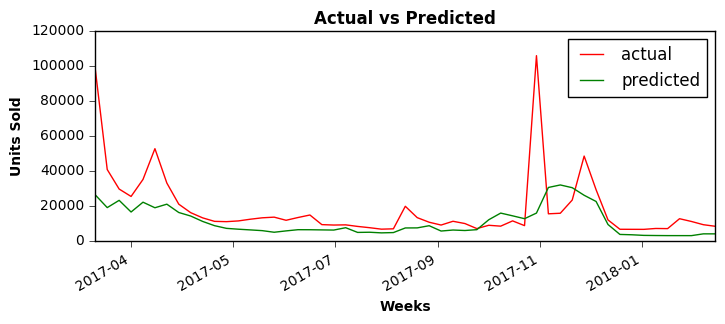

In [22]:
## For Plots using matplotlib

### Actual vs Predicted Chart
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
def get_actual_vs_predicted_plots(df_plot):
    df_plot = df_plot.sort_values(by = ['Week Ending'])
    weeks = df_plot['Week Ending']
    myFmt = DateFormatter("%Y-%m")
    plot_actual = df_plot['Units']
    plot_predicted = df_plot['Units-Predicted']
    fig = plt.figure(figsize=(8,3))
    ax = fig.add_subplot(111)
    ax.xaxis.set_major_formatter(myFmt)
    fig.autofmt_xdate()
    plt.plot(weeks, plot_actual, color='red',label='actual')
    plt.plot(weeks, plot_predicted, color='green',label='predicted')
    plt.title('Actual vs Predicted',fontweight='bold')  
    ax.set_xlabel('Weeks',color='black',fontweight='bold')
    ax.set_ylabel('Units Sold',color='black',fontweight='bold')
    ax.legend(loc='best')
    ax.tick_params(direction='out',top='off', bottom='on', left='on', right='off', labelleft='on', labelbottom='on')
    ax.xaxis.set_major_locator(plt.MaxNLocator(8))
    return plt

train_titles = ['Cars-3-Driven-to-Win','Lego Incredibles','Lego Marvel Super Hero 2','Lego Super DC','Lego Worlds']

title = "Lego Worlds"
df_plot = df_predicted_train_original
df_plot = df_plot[df_plot['Title']==title]
plt = get_actual_vs_predicted_plots(df_plot)
#plt.savefig(path+"\\plots\\actual_vs_predicted_"+"Lego Worlds"+".png")
plt.show()


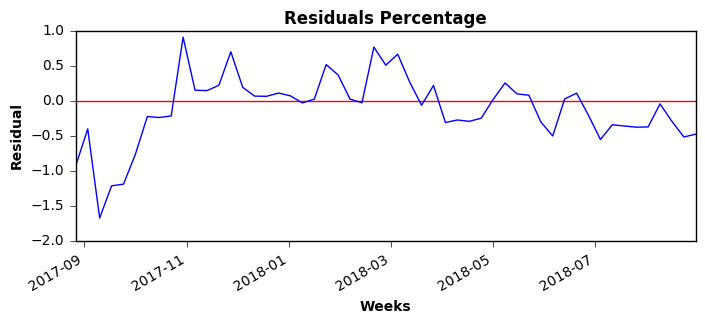

In [23]:
### Residuals Percentage Chart
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
train_titles = ['Cars-3-Driven-to-Win','Lego Incredibles','Lego Marvel Super Hero 2','Lego Super DC','Lego Worlds',
                'Scribblenauts Showdown/Scribblenauts Fiesta']
title = "Lego Ninjago Movie Videogame"
df_plot = df_predicted_test_original
df_plot = df_plot[df_plot['Title']==title]
df_plot = df_plot.sort_values(by = ['Week Ending'])
df_plot["zero line"] = 0.0
weeks = df_plot['Week Ending']
myFmt = DateFormatter("%Y-%m")
plot_residual = df_plot['Residuals Percentage']
plot_zeroline = df_plot["zero line"]
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(111)
ax.xaxis.set_major_formatter(myFmt)
fig.autofmt_xdate()
plt.plot(weeks, plot_zeroline, color='red')
plt.plot(weeks, plot_residual, color='blue')
plt.title('Residuals Percentage',fontweight='bold')  
ax.set_xlabel('Weeks',color='black',fontweight='bold')
ax.set_ylabel('Residual',color='black',fontweight='bold')
#ax.legend(loc='best')
ax.tick_params(direction='out',top='off', bottom='on', left='on', right='off', labelleft='on', labelbottom='on')
ax.xaxis.set_major_locator(plt.MaxNLocator(7))
#plt.savefig(path+"\\plots\\residuals_plot\\residual_plot_"+"Lego Ninjago Movie Videogame"+".png")
plt.show()


In [24]:
print(w_mape(np.exp(Y_train.values),np.exp(ypredict_train.values)))
print(w_mape(np.exp(Y_test.values),np.exp(ypredict_test.values)))

50.56353616483686
55.59988898561595


In [25]:
## To Calculate the marketing and non marketing contributions
def isBothContributionPositive(model_dict,marketingLnCols):
    lr_model_ols = model_dict["lr_model_ols"]
    XTrainScaledConst = model_dict["XTrainScaledConst"]
    XTestScaledConst = model_dict["XTestScaledConst"]
    Y_train = model_dict["Y_train"]
    Y_test = model_dict["Y_test"]
    column_names = model_dict["column_names"]
    ypredict_train = lr_model_ols.predict(XTrainScaledConst)
    ypredict_test = lr_model_ols.predict(XTestScaledConst)
    train_mape_ln = mean_absolute_percentage_error(Y_train,ypredict_train.values)
    test_mape_ln = mean_absolute_percentage_error(Y_test,ypredict_test.values)
    train_mape = mean_absolute_percentage_error(np.exp(Y_train.values),np.exp(ypredict_train.values))
    test_mape = mean_absolute_percentage_error(np.exp(Y_test.values),np.exp(ypredict_test.values))
    train_rsquare =  Rsquare(Y_train,ypredict_train.values)
    train_adjrsquare = adjRsquare(Y_train,ypredict_train.values,XTrainScaledConst.shape[1]-1)
    betaCoef = lr_model_ols.params
    ypred = lr_model_ols.predict(XTrainScaledConst)
    ypred_exp = np.exp(ypred.values)
    raw_contribution = getRawContributions(XTrainScaledConst,ypred_exp,betaCoef,column_names)
    scaled_contribution = getScaledContributions(XTrainScaledConst,ypred_exp,raw_contribution,column_names)
    scaled_contribution_df = pd.DataFrame(scaled_contribution,columns = column_names)
    grouped,total = getPercentMarketingContribution(scaled_contribution_df,marketingLnCols)
    total["Percent Marketing Contribution"] = (total["value"] / total["value"].sum())*100
    others_percent = grouped.loc[1,"percent"]
    marketing_percent = grouped.loc[0,"percent"]
    return (marketing_percent,others_percent,train_mape,test_mape,train_mape_ln,test_mape_ln)


In [26]:
isBothContributionPositive(model_dict,marketingLnCols)

(39.85174293117491,
 60.148257068825096,
 57.2598250383563,
 35.90445417166541,
 5.924510552331739,
 4.164222879966913)

In [27]:
print(train_mape)
print(test_mape)
print(train_mape_ln)
print(test_mape_ln)

57.2598250383563
35.90445417166541
5.924510552331739
4.164222879966913


# ROI Calculation

In [28]:
def getContributionsDF(X,ypred_exp,betaCoef,column_names,X_all):
    raw_contribution = getRawContributions(X,ypred_exp,betaCoef,column_names)
    scaled_contribution = getScaledContributions(X,ypred_exp,raw_contribution,column_names)
    scaled_contribution_df = pd.DataFrame(scaled_contribution,columns = column_names)
    scaled_contribution_df = scaled_contribution_df.set_index(X.index)
    scaled_contribution_df = pd.concat([scaled_contribution_df,X_all[['Title','Week Ending']]],axis=1)
    return scaled_contribution_df

def getROIChannelWise(X,Y,marketingLnCols,marketing_non_ads_cols,total):
    X_df = X.copy()
    Y_df = Y.copy().to_frame()
    Y_df['Units'] = np.exp(Y.values)
    df_train = pd.concat([X_df,Y_df],axis=1)
    #marketing_non_ads_cols = [x.split("_")[2] for x in marketingLnCols] 
    marketing_ln_ads_cols = marketingLnCols
    total_units = df_train['Units'].sum()
    Total_Revenue = (df_train['Total Revenue']).sum()
    marketing_spend = df_train[marketing_non_ads_cols].sum().to_frame(name= "Spend").reset_index()
    marketing_spend['marketing_variables'] = marketing_spend['index']
    marketing_spend = marketing_spend.drop(['index'],axis=1)
    marketing_contribution = total.copy()
    marketing_contribution = marketing_contribution[marketing_contribution.variables.isin(marketing_ln_ads_cols)]
    marketing_contribution['Total Units'] = total_units
    marketing_contribution['Total_Revenue'] = Total_Revenue
    marketing_contribution = marketing_contribution.drop(['value','Marketing_Variables'],axis=1).reset_index()
    marketing = pd.concat([marketing_contribution,marketing_spend],axis=1).drop(['index'],axis=1)
    marketing['ROMI_In_Revenue_Terms'] = (marketing['Total_Revenue'] * marketing['Percent Marketing Contribution'])/(100 * marketing['Spend'])
    marketing['ROMI_In_Units_Terms'] = (marketing['Total Units'] * marketing['Percent Marketing Contribution'])/(100 * marketing['Spend'])
    return marketing

def getROI_title_channel_wise(titles,scaled_contribution_df,X_all,Y,marketingLnCols,marketing_non_ads_cols):
    dic_mkt_tit_chan_wise = {}
    for title in titles:
        scaled_contribution_title = scaled_contribution_df[scaled_contribution_df['Title']==title]
        grouped_title,total_title = getPercentMarketingContribution(scaled_contribution_title,marketingLnCols)
        X_title = X_all[X_all['Title']==title]
        Y_title = Y[Y.index.isin(X_title.index)]
        marketing_title_channel_wise = getROIChannelWise(X_title,Y_title,marketingLnCols,marketing_non_ads_cols,total_title)
        dic_mkt_tit_chan_wise[title] = (marketing_title_channel_wise,grouped_title,total_title)
    return dic_mkt_tit_chan_wise


In [29]:
marketingLnCols

['ln_ads_TVSpend_D1_S8',
 'ln_ads_Facebook_D13_S7',
 'ln_ads_Video_D3_S4',
 'ln_ads_Display_D13_S15',
 'ln_ads_Search_D3_S4',
 'ln_POSRebate',
 'ln_TradeDisplayPlacement']

# ROI  Overall - Channel Wise

In [30]:
scaled_contribution_df = getContributionsDF(XTrainScaledConst.copy(),ypred_exp,betaCoef,column_names,X_train_all.copy())
grouped,total = getPercentMarketingContribution(scaled_contribution_df,marketingLnCols)
marketing_channel_wise = getROIChannelWise(X_train_all,Y_train,marketingLnCols,marketing_non_ads_cols,total)

In [31]:
grouped

Marketing_Variables         value    percent
0           marketing  1.195843e+06  39.851743
1              others  1.804887e+06  60.148257

In [32]:
total

variables         value Marketing_Variables  \
0                      const  1.482717e+06              others   
1              Calender Week -4.031831e+05              others   
2                        Dec  1.457356e+05              others   
3                        Mar  3.476707e+04              others   
4                        Jul  1.759349e+04              others   
5                   1st week  1.757093e+04              others   
6                   2nd week -1.264859e+05              others   
7                  Is Action  1.963903e+05              others   
8              Is Open World  8.867336e+04              others   
9                 same genre -8.665804e+03              others   
10           different genre -3.738665e+04              others   
11               Week Number  1.106004e+04              others   
12              TubularViews  3.861009e+05              others   
13      ln_ads_TVSpend_D1_S8  3.915801e+04           marketing   
14    ln_ads_Facebook_D13_S7  1.015117e+05           marketing   
15        ln_ads_Video_D3_S4  2.435946e+05           marketing   
16    ln_ads_Display_D13_S15  1.698963e+05           marketing   
17       ln_ads_Search_D3_S4  2.809352e+04           marketing   
18              ln_POSRebate  4.899335e+04           marketing   
19  ln_TradeDisplayPlacement  5.645960e+05           marketing   

    Percent Marketing Contribution  
0                        49.411863  
1                       -13.436164  
2                         4.856669  
3                         1.158620  
4                         0.586307  
5                         0.585555  
6                        -4.215169  
7                         6.544750  
8                         2.955059  
9                        -0.288790  
10                       -1.245918  
11                        0.368578  
12                       12.866897  
13                        1.304949  
14                        3.382901  
15                        8.117842  
16                        5.661830  
17                        0.936223  
18                        1.632714  
19                       18.815284

In [33]:
marketing_channel_wise

variables  Percent Marketing Contribution  Total Units  \
0      ln_ads_TVSpend_D1_S8                        1.304949    3477740.0   
1    ln_ads_Facebook_D13_S7                        3.382901    3477740.0   
2        ln_ads_Video_D3_S4                        8.117842    3477740.0   
3    ln_ads_Display_D13_S15                        5.661830    3477740.0   
4       ln_ads_Search_D3_S4                        0.936223    3477740.0   
5              ln_POSRebate                        1.632714    3477740.0   
6  ln_TradeDisplayPlacement                       18.815284    3477740.0   

   Total_Revenue         Spend    marketing_variables  ROMI_In_Revenue_Terms  \
0   1.363231e+08  8.857741e+06                TVSpend               0.200835   
1   1.363231e+08  5.971686e+05               Facebook               7.722571   
2   1.363231e+08  1.853714e+06                  Video               5.969906   
3   1.363231e+08  1.006479e+06                Display               7.668703   
4   1.363231e+08  2.640967e+05                 Search               4.832655   
5   1.363231e+08  1.473283e+07              POSRebate               0.151075   
6   1.363231e+08  3.066379e+06  TradeDisplayPlacement               8.364780   

   ROMI_In_Units_Terms  
0             0.005124  
1             0.197011  
2             0.152298  
3             0.195636  
4             0.123286  
5             0.003854  
6             0.213394

In [34]:
marketing_channel_wise[marketing_channel_wise.marketing_variables=="Display"]['ROMI_In_Revenue_Terms'].values[0]

7.668702969270878

# ROI  Train Title- Channel Wise 

In [35]:
## In the dictionary of roi - title-channel wise, we get roi and grouped contributions
train_titles = ['Cars-3-Driven-to-Win','Lego Incredibles','Lego Marvel Super Hero 2','Lego Super DC','Lego Worlds',
                'Scribblenauts Showdown/Scribblenauts Fiesta']
scaled_contribution_df_train = getContributionsDF(XTrainScaledConst.copy(),ypred_exp,betaCoef,column_names,X_train_all)
dic_mkt_tit_chan_wise_train = getROI_title_channel_wise(train_titles,scaled_contribution_df_train,X_train_all.copy(),Y_train,marketingLnCols,marketing_non_ads_cols)


In [36]:
X_train_all['ypred'] = ypred_exp
title_pred = X_train_all[['Title','Week Number','Total Units','ypred']]
#title_pred.to_excel("D://Affine_Projects//WB_Warner_Bros//MMM//Optimisation//22072019//pred.xlsx")
title_pred.groupby(['Title'])['ypred'].sum()

Title
Cars-3-Driven-to-Win                           355509.914414
Lego Incredibles                               508125.936404
Lego Marvel Super Hero 2                       848875.037727
Lego Super DC                                  452199.362516
Lego Worlds                                    581588.607647
Scribblenauts Showdown/Scribblenauts Fiesta    254431.826055
Name: ypred, dtype: float64

In [37]:
### Scaled Contribution for each title
dic_mkt_tit_chan_wise_train['Lego Super DC'][2]

variables          value Marketing_Variables  \
0                      const  196630.517847              others   
1              Calender Week  -75349.378822              others   
2                        Dec   28684.138513              others   
3                        Mar    2867.596738              others   
4                        Jul       0.000000              others   
5                   1st week    3809.398053              others   
6                   2nd week  -31627.181280              others   
7                  Is Action   30371.157782              others   
8              Is Open World       0.000000              others   
9                 same genre       0.000000              others   
10           different genre   -4147.010265              others   
11               Week Number     578.677770              others   
12              TubularViews   83788.817381              others   
13      ln_ads_TVSpend_D1_S8    8704.114405           marketing   
14    ln_ads_Facebook_D13_S7   36451.355771           marketing   
15        ln_ads_Video_D3_S4   46651.478706           marketing   
16    ln_ads_Display_D13_S15       0.000000           marketing   
17       ln_ads_Search_D3_S4    8857.296554           marketing   
18              ln_POSRebate    9026.078489           marketing   
19  ln_TradeDisplayPlacement  106902.304873           marketing   

    Percent Marketing Contribution  
0                        43.483148  
1                       -16.662867  
2                         6.343251  
3                         0.634144  
4                         0.000000  
5                         0.842416  
6                        -6.994079  
7                         6.716320  
8                         0.000000  
9                         0.000000  
10                       -0.917076  
11                        0.127970  
12                       18.529176  
13                        1.924840  
14                        8.060904  
15                       10.316573  
16                        0.000000  
17                        1.958715  
18                        1.996040  
19                       23.640525

In [38]:
dic_mkt_tit_chan_wise_train['Lego Super DC'][0]

variables  Percent Marketing Contribution  Total Units  \
0      ln_ads_TVSpend_D1_S8                        1.924840     456433.0   
1    ln_ads_Facebook_D13_S7                        8.060904     456433.0   
2        ln_ads_Video_D3_S4                       10.316573     456433.0   
3    ln_ads_Display_D13_S15                        0.000000     456433.0   
4       ln_ads_Search_D3_S4                        1.958715     456433.0   
5              ln_POSRebate                        1.996040     456433.0   
6  ln_TradeDisplayPlacement                       23.640525     456433.0   

   Total_Revenue         Spend    marketing_variables  ROMI_In_Revenue_Terms  \
0   2.070915e+07  1.367641e+06                TVSpend               0.291464   
1   2.070915e+07  2.022515e+05               Facebook               8.253807   
2   2.070915e+07  3.542865e+05                  Video               6.030357   
3   2.070915e+07  0.000000e+00                Display                    NaN   
4   2.070915e+07  1.236983e+05                 Search               3.279213   
5   2.070915e+07  4.322272e+06              POSRebate               0.095636   
6   2.070915e+07  6.964376e+05  TradeDisplayPlacement               7.029706   

   ROMI_In_Units_Terms  
0             0.006424  
1             0.181915  
2             0.132910  
3                  NaN  
4             0.072274  
5             0.002108  
6             0.154936

In [39]:
dic_mkt_tit_chan_wise_train['Scribblenauts Showdown/Scribblenauts Fiesta'][1]

Marketing_Variables          value    percent
0           marketing   51671.311547  20.308509
1              others  202760.514508  79.691491

# ROI Test Title - Channel Wise.

In [40]:
## For Test Title-Channel Wise
test_titles = ['Lego Ninjago Movie Videogame']
scaled_contribution_df_test = getContributionsDF(XTestScaledConst.copy(),y_pred_exp_test,betaCoef,column_names,X_test_all)
dic_mkt_tit_chan_wise_test = getROI_title_channel_wise(test_titles,scaled_contribution_df_test,X_test_all.copy(),Y_test,marketingLnCols,marketing_non_ads_cols)


In [41]:
dic_mkt_tit_chan_wise_test['Lego Ninjago Movie Videogame'][2]

variables          value Marketing_Variables  \
0                      const  219065.732464              others   
1              Calender Week  -50032.468381              others   
2                        Dec   15709.856623              others   
3                        Mar    3789.952713              others   
4                        Jul    1537.631316              others   
5                   1st week    2009.603384              others   
6                   2nd week  -14196.272162              others   
7                  Is Action   33836.456305              others   
8              Is Open World       0.000000              others   
9                 same genre    -740.452737              others   
10           different genre   -3959.884090              others   
11               Week Number    1780.570435              others   
12              TubularViews   13626.481961              others   
13      ln_ads_TVSpend_D1_S8    4606.089436           marketing   
14    ln_ads_Facebook_D13_S7   16714.525187           marketing   
15        ln_ads_Video_D3_S4   22704.929208           marketing   
16    ln_ads_Display_D13_S15   16102.367498           marketing   
17       ln_ads_Search_D3_S4    2660.407980           marketing   
18              ln_POSRebate    8828.313577           marketing   
19  ln_TradeDisplayPlacement   74245.888622           marketing   

    Percent Marketing Contribution  
0                        59.481901  
1                       -13.585084  
2                         4.265624  
3                         1.029068  
4                         0.417506  
5                         0.545658  
6                        -3.854648  
7                         9.187456  
8                         0.000000  
9                        -0.201052  
10                       -1.075209  
11                        0.483470  
12                        3.699935  
13                        1.250670  
14                        4.538417  
15                        6.164964  
16                        4.372201  
17                        0.722368  
18                        2.397111  
19                       20.159641

In [42]:

dic_mkt_tit_chan_wise_test['Lego Ninjago Movie Videogame'][0]

variables  Percent Marketing Contribution  Total Units  \
0      ln_ads_TVSpend_D1_S8                        1.250670     448459.0   
1    ln_ads_Facebook_D13_S7                        4.538417     448459.0   
2        ln_ads_Video_D3_S4                        6.164964     448459.0   
3    ln_ads_Display_D13_S15                        4.372201     448459.0   
4       ln_ads_Search_D3_S4                        0.722368     448459.0   
5              ln_POSRebate                        2.397111     448459.0   
6  ln_TradeDisplayPlacement                       20.159641     448459.0   

   Total_Revenue         Spend    marketing_variables  ROMI_In_Revenue_Terms  \
0   1.746701e+07  1.533098e+05                TVSpend               1.424923   
1   1.746701e+07  2.002589e+05               Facebook               3.958506   
2   1.746701e+07  3.338337e+05                  Video               3.225663   
3   1.746701e+07  3.810707e+04                Display              20.040713   
4   1.746701e+07  1.468425e+04                 Search               8.592618   
5   1.746701e+07  4.861130e+06              POSRebate               0.086133   
6   1.746701e+07  1.014932e+06  TradeDisplayPlacement               3.469480   

   ROMI_In_Units_Terms  
0             0.036584  
1             0.101633  
2             0.082818  
3             0.514538  
4             0.220612  
5             0.002211  
6             0.089078

In [43]:
dic_mkt_tit_chan_wise_test['Lego Ninjago Movie Videogame'][1]

Marketing_Variables          value    percent
0           marketing  145862.521509  39.605373
1              others  222427.207831  60.394627